In [1]:


import numpy as np
import pandas as pd
from scipy import sparse

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Uncomment df to choose which dataset to use
#df = pd.read_csv('Guardian_reviews_ready_relevant_info.csv', usecols = ['review_text', 'stars'])
#df = pd.read_csv('Guardian_reviews_ready_oversampled_and_undersampled.csv', usecols = ['review_text', 'stars'])
#df = pd.read_csv('Guardian_reviews_ready_oversampled.csv', usecols = ['review_text', 'stars'])
#df = pd.read_csv('Guardian_reviews_ready_oversampled_and_undersampled_1and2stars.csv', usecols = ['review_text', 'stars'])
df = pd.read_csv('Guardian_reviews_ready_oversampled_and_undersampled(max=2549).csv', usecols = ['review_text', 'stars'])



,review_text,stars
0,the early 16th century playwright Jill Vicente...,1
1,"""HitsvilleUSA, Motown's 1960 chart headed to a...",1
2,"""English National Opera opens their new seas...",1
3,"""have you ever heard of two Frenchmen,two Amer...",1
4,Opera Holland Park should exist why someone ca...,1


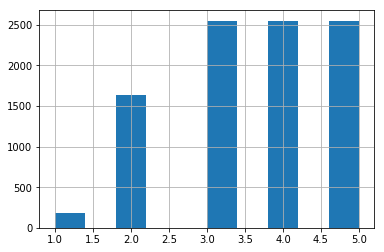

In [3]:
# Show test set
df['stars'].hist();df.head()

In [4]:
df_count = df.groupby('stars')['review_text'].count()
print(df_count)

stars
1     188
2    1640
3    2549
4    2549
5    2549
Name: review_text, dtype: int64


In [5]:
df_unique = df.groupby('stars')['review_text'].nunique()
print(df_unique)

stars
1     188
2    1640
3    2549
4    2549
5    2549
Name: review_text, dtype: int64


In [6]:
# Import stopwords with nltk.
#from nltk.corpus import stopwords
#stop = stopwords.words('english')

#df.columns = ["review_text","class"]

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
#df['review_text_without_stopwords'] = df['review_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#print(df)

,review_text,stars
7504,There is a certain thrill to seeing a band in ...,5
1829,Yuri Temirkanov is best known for his work wit...,3
1875,Anyone concerned that major-league hip-hop is ...,3
5009,"In pop, the word ""troubled"" is normally follow...",4
8178,who leadsthe BBC Philharmonic Orchestra; revol...,5


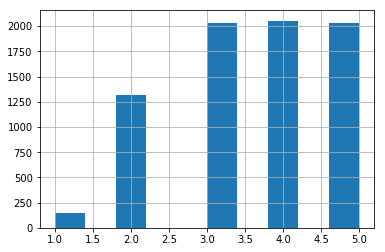

In [7]:
# shuffle df
from sklearn.utils import shuffle

# Shuffle dataset to randomize
df = shuffle(df)

# Split into train and test set 
train, test = train_test_split(df, test_size=0.2)

# Show train set
train['stars'].hist();train.head()




In [8]:
# For Train set, use get_dummies to create columns for each stars and show whther there is a value or not (0 or 1)  
train = pd.get_dummies(train, columns = ['stars'])
train.head()

,review_text,stars_1,stars_2,stars_3,stars_4,stars_5
7504,There is a certain thrill to seeing a band in ...,0,0,0,0,1
1829,Yuri Temirkanov is best known for his work wit...,0,0,1,0,0
1875,Anyone concerned that major-league hip-hop is ...,0,0,1,0,0
5009,"In pop, the word ""troubled"" is normally follow...",0,0,0,1,0
8178,who leadsthe BBC Philharmonic Orchestra; revol...,0,0,0,0,1


In [9]:
# For Test set, use get_dummies to create columns for each stars and show whther there is a value or not (0 or 1)
test = pd.get_dummies(test, columns = ['stars'])
#train.shape, test.shape
test.head()

,review_text,stars_1,stars_2,stars_3,stars_4,stars_5
7166,including perfect attention to detail and lase...,0,0,0,0,1
1496,The best moment in this concert celebrating Mi...,0,1,0,0,0
3850,"On a clear and warm Saturday night in Sydney, ...",0,0,1,0,0
6905,Within five years at the start of the 20th cen...,0,0,0,1,0
435,"Some experiences are critic-proof, and they in...",0,1,0,0,0


In [10]:
# tokenizing and tfidf calcuation is all done with sklearn's TfidfVectorizer method.
# max_features is an upper bound on the number of words in the vocabulary
max_features = 20000
tfidf = TfidfVectorizer(max_features = max_features)

In [11]:
class NBFeatures(BaseEstimator):
    '''Class implementation of Jeremy Howards NB Linear model'''
    def __init__(self, alpha):
        # Smoothing Parameter: always going to be one for my use
        self.alpha = alpha
        
    def preprocess_x(self, x, r):
        return x.multiply(r)
    
    # calculate probabilities
    def pr(self, x, y_i, y):
        p = x[y == y_i].sum(0)
        return (p + self.alpha)/((y==y_i).sum()+self.alpha)
    
    # calculate the log ratio and represent as sparse matrix
    # ie fit the nb model
    def fit(self, x, y = None):
        self._r = sparse.csr_matrix(np.log(self.pr(x, 1, y) /self.pr(x, 0, y)))
        return self
    
    # apply the nb fit to original features x
    def transform(self, x):
        x_nb = self.preprocess_x(x, self._r)
        return x_nb

In [12]:
# Create pipeline using sklearn pipeline:
    # I basically create my tfidf features which are fed to my NB model 
    # for probability calculations. Then those are fed as input to my 
    # logistic regression model.
lr = LogisticRegression()
nb = NBFeatures(1)
p = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb),
    ('lr', lr)
])


    #('bc', StackingClassifier(lr, 
                      #n_estimators=100, bootstrap=True, bootstrap_features=True, random_state=0))
     

In [13]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
scores = []
preds = np.zeros((len(test), len(class_names)))
for i, class_name in enumerate(class_names):
    train_target = train[class_name]    
    cv_score = np.mean(cross_val_score(estimator = p, X = train['review_text'].values, 
                                      y = train_target, cv = 3, scoring = 'accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))
    p.fit(train['review_text'].values, train_target)
    preds[:,i] = p.predict_proba(test['review_text'].values)[:,1]

CV score for class stars_1 is 0.98179419461685
CV score for class stars_2 is 0.8591025841471621
CV score for class stars_3 is 0.7356204091092003
CV score for class stars_4 is 0.7319261816666098
CV score for class stars_5 is 0.8106855044432768


In [14]:
t = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(t)

              precision    recall  f1-score   support

           0       1.00      0.26      0.41        46
           1       0.76      0.64      0.69       320
           2       0.52      0.54      0.53       517
           3       0.46      0.50      0.48       495
           4       0.69      0.71      0.70       517

    accuracy                           0.59      1895
   macro avg       0.69      0.53      0.56      1895
weighted avg       0.60      0.59      0.59      1895



In [15]:
v = metrics.confusion_matrix(np.argmax(test[class_names].values, axis = 1),np.argmax(preds, axis = 1))
print(v)

[[ 12  10  14   2   8]
 [  0 205  57  28  30]
 [  0  29 281 161  46]
 [  0  15 150 247  83]
 [  0  11  37 101 368]]


In [16]:
# Technique 2

# Word vectors to get pretrained word embeddings
embed_size = 200 
# max number of unique words
max_features = 20000
# max number of words from review to use. Reviews must be same lenght. 
maxlen = 250

# File path to Twitter and Common Crawl embeddings
embedding_file = '/Users/clausholm/Documents/Python/Libaries/glove.twitter.27B/glove.twitter.27B.200d.txt'
#embedding_file = '/Users/clausholm/Documents/Python/review_predictor/crawl-300d-2M-subword.vec'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/clausholm/Documents/Python/Libaries/glove.twitter.27B/glove.twitter.27B.200d.txt'

In [35]:
class_names = ['stars_1', 'stars_2', 'stars_3', 'stars_4', 'stars_5']
# Splitting off my y variable
y = train[class_names].values

In [36]:
# Tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train['review_text'].values))
X_train = tokenizer.texts_to_sequences(train['review_text'].values)
X_test = tokenizer.texts_to_sequences(test['review_text'].values)

# Padding added if there is not enough words in a review
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [37]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [38]:
len(missed)

2705

In [39]:
missed[0:10]

["it's",
 'it’s',
 "don't",
 "there's",
 "doesn't",
 "he's",
 '10',
 "can't",
 '1',
 "i'm"]

In [40]:
missed[1000:1010]

['01223',
 '3333',
 'arditti',
 'bartók’s',
 'takacs',
 'ruminations',
 'mesmeric',
 'eschews',
 'unremitting',
 'smith’s']

In [56]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'softmax')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [57]:
model.fit(x_train, y, batch_size = 64, epochs = 50, validation_split = 0.1,
          callbacks=[earlystop, checkpoint])

Train on 6822 samples, validate on 758 samples
Epoch 1/50
6822/6822 [==============================] - 20s 3ms/step - loss: 0.4928 - accuracy: 0.7894 - val_loss: 0.4721 - val_accuracy: 0.8000
Epoch 2/50
6822/6822 [==============================] - 19s 3ms/step - loss: 0.4569 - accuracy: 0.7999 - val_loss: 0.4646 - val_accuracy: 0.7937
Epoch 3/50
6822/6822 [==============================] - 21s 3ms/step - loss: 0.4398 - accuracy: 0.8028 - val_loss: 0.4535 - val_accuracy: 0.8013
Epoch 4/50
6822/6822 [==============================] - 21s 3ms/step - loss: 0.4253 - accuracy: 0.8040 - val_loss: 0.4234 - val_accuracy: 0.8092
Epoch 5/50
6822/6822 [==============================] - 21s 3ms/step - loss: 0.4025 - accuracy: 0.8113 - val_loss: 0.4007 - val_accuracy: 0.8172
Epoch 6/50
6822/6822 [==============================] - 23s 3ms/step - loss: 0.3793 - accuracy: 0.8235 - val_loss: 0.3937 - val_accuracy: 0.8137
Epoch 7/50
6822/6822 [==============================] - 21s 3ms/step - loss: 0.3433

In [58]:
y_test = model.predict([x_test], batch_size=1024, verbose = 1)

1895/1895 [==============================] - 2s 882us/step


In [59]:
model.evaluate(x_test, test[class_names].values, verbose = 1, batch_size=1024)


1895/1895 [==============================] - 2s 904us/step


[0.3483265312649015, 0.837678074836731]

In [60]:
print (model.metrics_names)

['loss', 'accuracy']


In [61]:
v = metrics.classification_report(np.argmax(test[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.66      0.63      0.65       299
           2       0.48      0.72      0.58       493
           3       0.52      0.44      0.47       528
           4       0.79      0.63      0.70       546

    accuracy                           0.59      1895
   macro avg       0.49      0.48      0.48      1895
weighted avg       0.60      0.59      0.59      1895



In [62]:
v = metrics.confusion_matrix(np.argmax(test[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

[[  0  23   5   1   0]
 [  0 189  88   6  16]
 [  0  40 353  80  20]
 [  0  11 232 231  54]
 [  0  24  52 127 343]]


In [ ]:
import matplotlib.pyplot as plt
plt.matshow(v, cmap=plt.cm.gray)
plt.show()

In [ ]:
v = keras.metrics.accuracy(y_true, y_pred)